### Hypothyroid Prediction Model - 
Description: Building a machine learning pipeline to predict whether a patient is suffering
             from hypothyroidism based on clinical data. The dataset contains categorical and numerical
             health indicators, and the target variable is 'binaryClass' (P = Positive, N = Negative).

### What is Hypothyroidism?
Hypothyroidism is a common condition in which the thyroid gland does not produce enough thyroid hormone.
This can lead to symptoms such as fatigue, weight gain, cold intolerance, and depression.
Early prediction can help in timely treatment and prevention of complications.

#### Goal-
Given patient features such as TSH, T3, age, sex, and other hormone levels, the objective is to build
an accurate classifier that can predict if a patient is hypothyroid (P) or not (N).


In [1]:
# 3. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load Data
file_path = 'hypothyroid_classification.csv'
df = pd.read_csv(file_path, na_values='?')

In [3]:
# Data Preprocessing
## Drop Duplicates and Fix Column Names
df.drop_duplicates(inplace=True)
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

In [4]:
## Check Missing Values
print("\nMissing values before filtering:\n", df.isnull().sum())


Missing values before filtering:
 age                             1
sex                           149
on_thyroxine                    0
query_on_thyroxine              0
on_antithyroid_medication       0
sick                            0
pregnant                        0
thyroid_surgery                 0
i131_treatment                  0
query_hypothyroid               0
query_hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
hypopituitary                   0
psych                           0
tsh_measured                    0
tsh                           309
t3_measured                     0
t3                            709
tt4_measured                    0
tt4                           171
t4u_measured                    0
t4u                           327
fti_measured                    0
fti                           325
tbg_measured                    0
tbg                          3711
referral_sour

In [5]:
## Drop columns with >60% missing
df = df[df.columns[df.isnull().mean() < 0.6]]

In [6]:
## Encode Target
df['binaryclass'] = LabelEncoder().fit_transform(df['binaryclass'])  # P=1, N=0

In [7]:
# Split Features and Target
X = df.drop('binaryclass', axis=1)
y = df['binaryclass']


In [8]:
# Identify Columns by Type
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns


In [9]:
# Impute Categorical with Mode
X[cat_cols] = SimpleImputer(strategy='most_frequent').fit_transform(X[cat_cols])


In [10]:
# Impute Numerical with KNN
X[num_cols] = KNNImputer(n_neighbors=3).fit_transform(X[num_cols])

In [11]:
# One-hot encode categoricals
X = pd.get_dummies(X, drop_first=True)

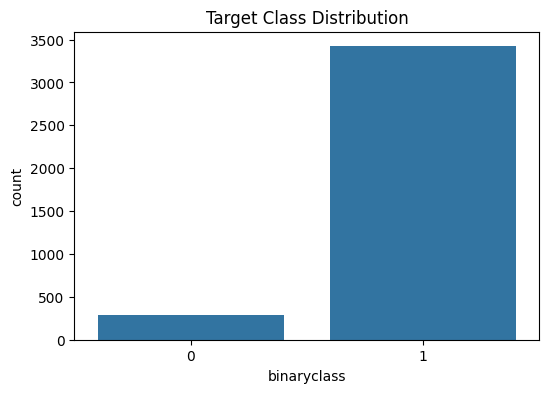

In [12]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title("Target Class Distribution")
plt.show()

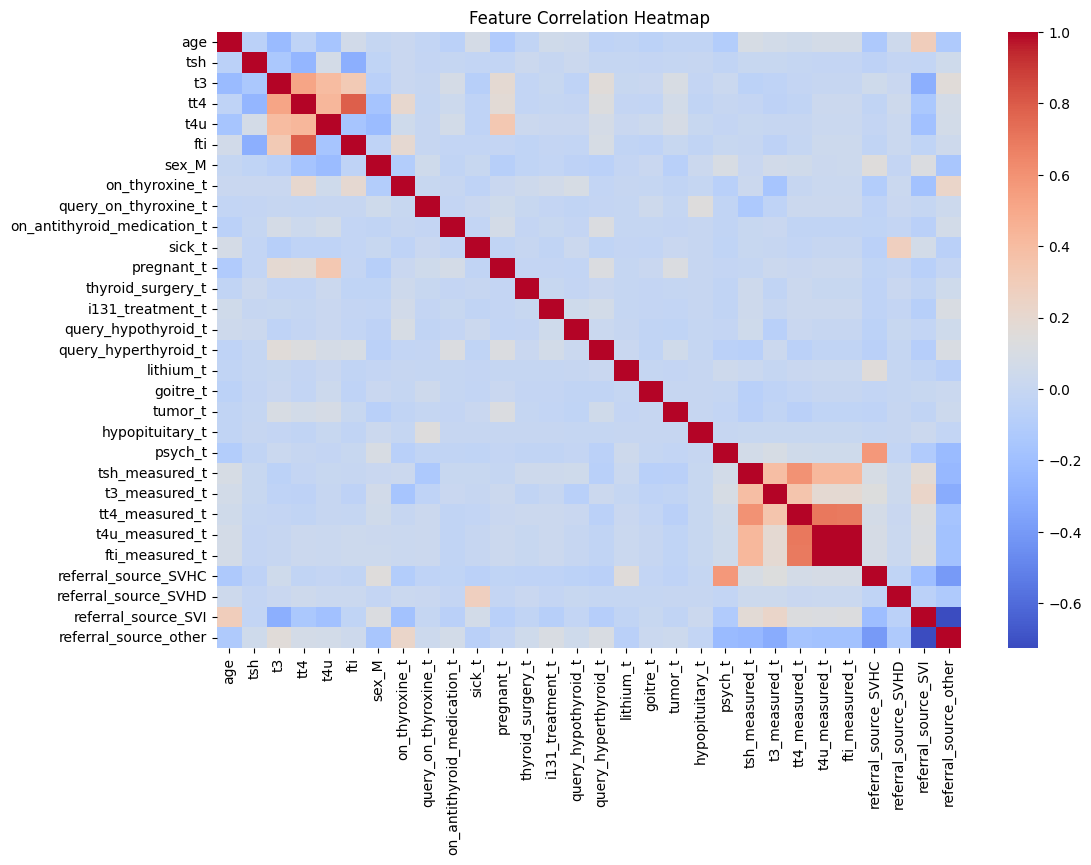

In [13]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pd.DataFrame(X, columns=X.columns).corr(), cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


In [14]:
# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [15]:
# 8. Handle Imbalanced Data
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_scaled, y)


In [16]:
# 9. Split Data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, stratify=y_res, random_state=42)


In [17]:
# 10. Model Building with Cross-Validation
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0)
}

In [18]:
for name, model in models.items():
    scores = cross_val_score(model, X_res, y_res, cv=5, scoring='f1')
    print(f"\n{name} Cross-Validation F1 Score: {scores.mean():.4f} ± {scores.std():.4f}")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"{name} Test Set Performance:")
    print(classification_report(y_test, preds))
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))



LogisticRegression Cross-Validation F1 Score: 0.9824 ± 0.0047
LogisticRegression Test Set Performance:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       684
           1       0.98      0.98      0.98       684

    accuracy                           0.98      1368
   macro avg       0.98      0.98      0.98      1368
weighted avg       0.98      0.98      0.98      1368

Confusion Matrix:
 [[671  13]
 [ 14 670]]

DecisionTree Cross-Validation F1 Score: 0.9972 ± 0.0014
DecisionTree Test Set Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       684
           1       1.00      1.00      1.00       684

    accuracy                           1.00      1368
   macro avg       1.00      1.00      1.00      1368
weighted avg       1.00      1.00      1.00      1368

Confusion Matrix:
 [[682   2]
 [  1 683]]

RandomForest Cross-Validation F1 Score: 0.9972 ± 0.0006
RandomFor

In [19]:
# 11. Ensemble Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('rf', models['RandomForest']),
    ('xgb', models['XGBoost']),
    ('lgbm', models['LightGBM'])
], voting='soft')
voting_clf.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 2736, number of negative: 2736
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2094
[LightGBM] [Info] Number of data points in the train set: 5472, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                             ('lgbm', LGBMClassifier())],
                 voting='soft')

In [20]:
# 12. Evaluation
preds = voting_clf.predict(X_test)
probs = voting_clf.predict_proba(X_test)[:, 1]
print("\nEnsemble Model Performance:")
print(classification_report(y_test, preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
print("ROC-AUC Score:", roc_auc_score(y_test, probs))



Ensemble Model Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       684
           1       1.00      1.00      1.00       684

    accuracy                           1.00      1368
   macro avg       1.00      1.00      1.00      1368
weighted avg       1.00      1.00      1.00      1368

Confusion Matrix:
 [[683   1]
 [  1 683]]
ROC-AUC Score: 0.9999871755411921


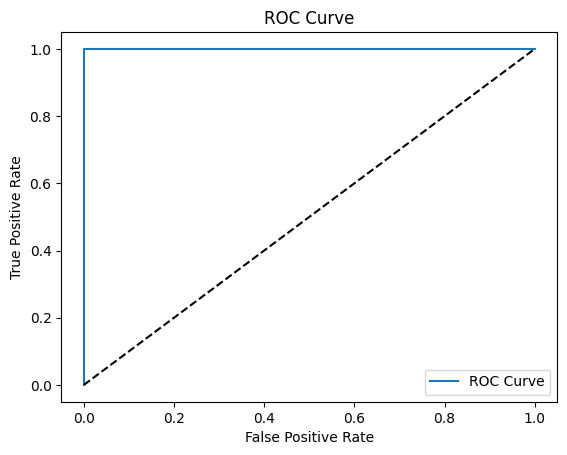

In [21]:
fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure()
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [22]:
# 13. Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

In [23]:
gs = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, scoring='f1', cv=5)
gs.fit(X_train, y_train)
print("\nBest Parameters (Random Forest):", gs.best_params_)
best_model = gs.best_estimator_



Best Parameters (Random Forest): {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


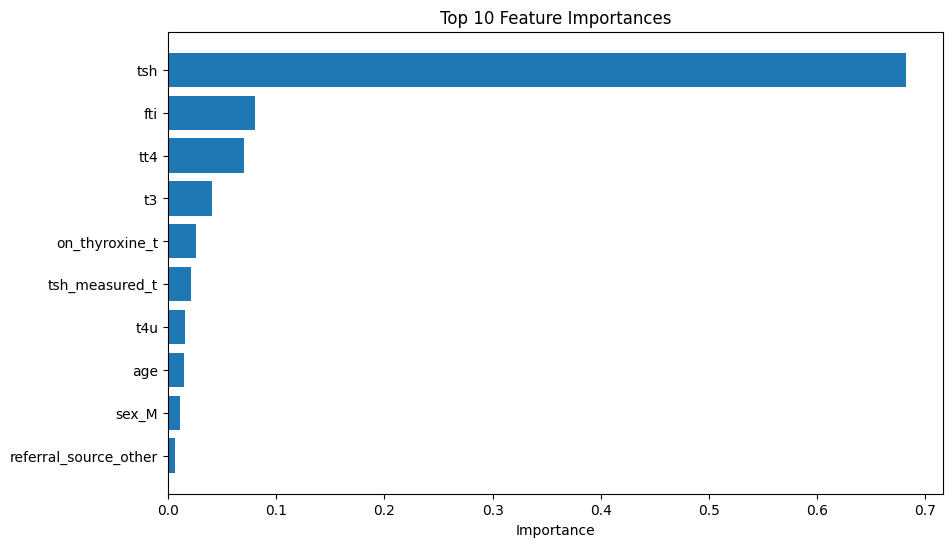

In [24]:
# 15. Reporting & Interpretation
importances = best_model.feature_importances_
indices = np.argsort(importances)[-10:]
plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances")
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel("Importance")
plt.show()


In [25]:
import joblib

# Replace this path if needed
joblib.dump(best_model, 'hypothyroid_final_model.pkl')
print("Model saved successfully!")

Model saved successfully!


## Hypothyroid Prediction Project – Summary Report

### 1. Problem Definition
Hypothyroidism is a medical condition where the thyroid gland fails to produce sufficient thyroid hormones.  
This can lead to weight gain, fatigue, and other metabolic issues.  
The aim of this project is to predict whether a patient is hypothyroid (**P**) or not (**N**) based on clinical and demographic features.

---

### 2. Data Collection
- **Dataset**: `hypothyroid_classification.csv`  
- Contains patient medical test records and a target label (`binaryClass`) indicating hypothyroid status.
#### Before any cleaning:
- **Total Rows**: 3772  
- **Total Columns**: 30  
- **Target Column**: `binaryClass` (P = Positive / Hypothyroid, N = Negative / Normal)

- **Replacing Missing Values**

#### Placeholder Handling
- The dataset uses `'?'` as a placeholder for missing values.
- Converted all `'?'` to `np.nan` using:

---

### 3. Data Preprocessing

#### Cleaning:
- Dropped duplicate rows.
- Fixed column names (converted to lowercase, removed spaces).
- Replaced all `?` symbols with `np.nan` using `na_values='?'`.
- **Dataset Shape After Cleaning**
- **Total Rows**: `3734`  
- **Total Columns**: ~`50+` (after encoding categorical variables)

_Initial rows: 3772 → Duplicates removed: 38_


#### Handling Missing Values:
- Dropped columns with more than 60% missing values.
- **Categorical features**: Imputed using most frequent (mode).
- **Numerical features**: Imputed using `KNNImputer` (k=3).

#### Encoding:
- **Target**: Encoded with `LabelEncoder` (P → 1, N → 0).
- **Features**: One-hot encoded for categorical columns.

---

### 4. Exploratory Data Analysis (EDA)

#### Target Distribution:
- Visualized using seaborn `countplot`.
- Found class imbalance: **Class P (positive)** is dominant.

#### Correlation Heatmap:
- Used `sns.heatmap` to show correlation matrix.
- Helped identify redundant or highly correlated features.

---

### 5. Feature Engineering & Scaling
- Scaled numerical features using `StandardScaler`.
- Scaling helps models like Logistic Regression and KNN perform better.

---

## 6. Imbalanced Data Handling
- Used **SMOTE** (Synthetic Minority Over-sampling Technique).
- Balanced the minority class (N) by generating synthetic samples.

---

### 7. Splitting the Data
- Used `train_test_split` with **80:20** ratio.
- Stratified splitting preserved class proportions in train/test sets.

---

### 8. Model Building (with Cross-Validation)

#### Models Trained:
- Logistic Regression  
- Decision Tree  
- Random Forest  
- XGBoost  
- LightGBM  
- CatBoost  

#### Cross-Validation:
- Applied 5-fold cross-validation using `cross_val_score` with F1 score.
- Reported **mean ± standard deviation** of F1-score for each model.

---

### 9. Ensemble Model: Voting Classifier
- Combined top 3 models:
  - Random Forest
  - XGBoost
  - LightGBM  
- Used **soft voting** to improve generalization and accuracy.

---

### 10. Evaluation Metrics

#### On the Test Set:
- Classification report (Precision, Recall, F1-score).
- Confusion matrix.
- ROC-AUC score.
- ROC Curve visualization with `roc_curve()` and `plt.plot()`.

---

### 11. Hyperparameter Tuning

- Used `GridSearchCV` to tune Random Forest:
  - `n_estimators`: [100, 200]
  - `max_depth`: [10, 20, None]
  - `min_samples_split`: [2, 5]
- 5-fold cross-validation and F1-score as scoring metric.

---

### 12. Final Model & Saving

- Saved the best model using:
  ```python
  joblib.dump(best_model, 'hypothyroid_final_model.pkl')


#### Name - Aman Kumar
#### SIC - 22bcsi16